In [60]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules
from sklearn.linear_model import LinearRegression as LM

# For evaluating our model's performance
import sklearn.metrics as m
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in data 
df = pd.read_csv("../DATA/nft_projects_success.csv")

In [3]:
# Specify y values
y = df['Success']

In [61]:
# Specify X values 
X = df[['Number of Tokens Minted', 'quantity_adjusted_start', 'average_adjusted_start', 'tokens_start', 'tokens_bought_2_weeks', 'quantity_adjusted_2', 'average_adjusted_2', 'tokens_bought_month', 'quantity_adjusted_month', 'average_adjusted_month', 'Art','Discord Channel','Interactive Experience ', 'Access & Utility']] 
X['tokens_start'] = np.log(X['tokens_start']) # Log tokens_start due to high variance

In [6]:
# Split data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=123)

### Data Exploration

In [93]:
train_X.shape 

(69, 14)

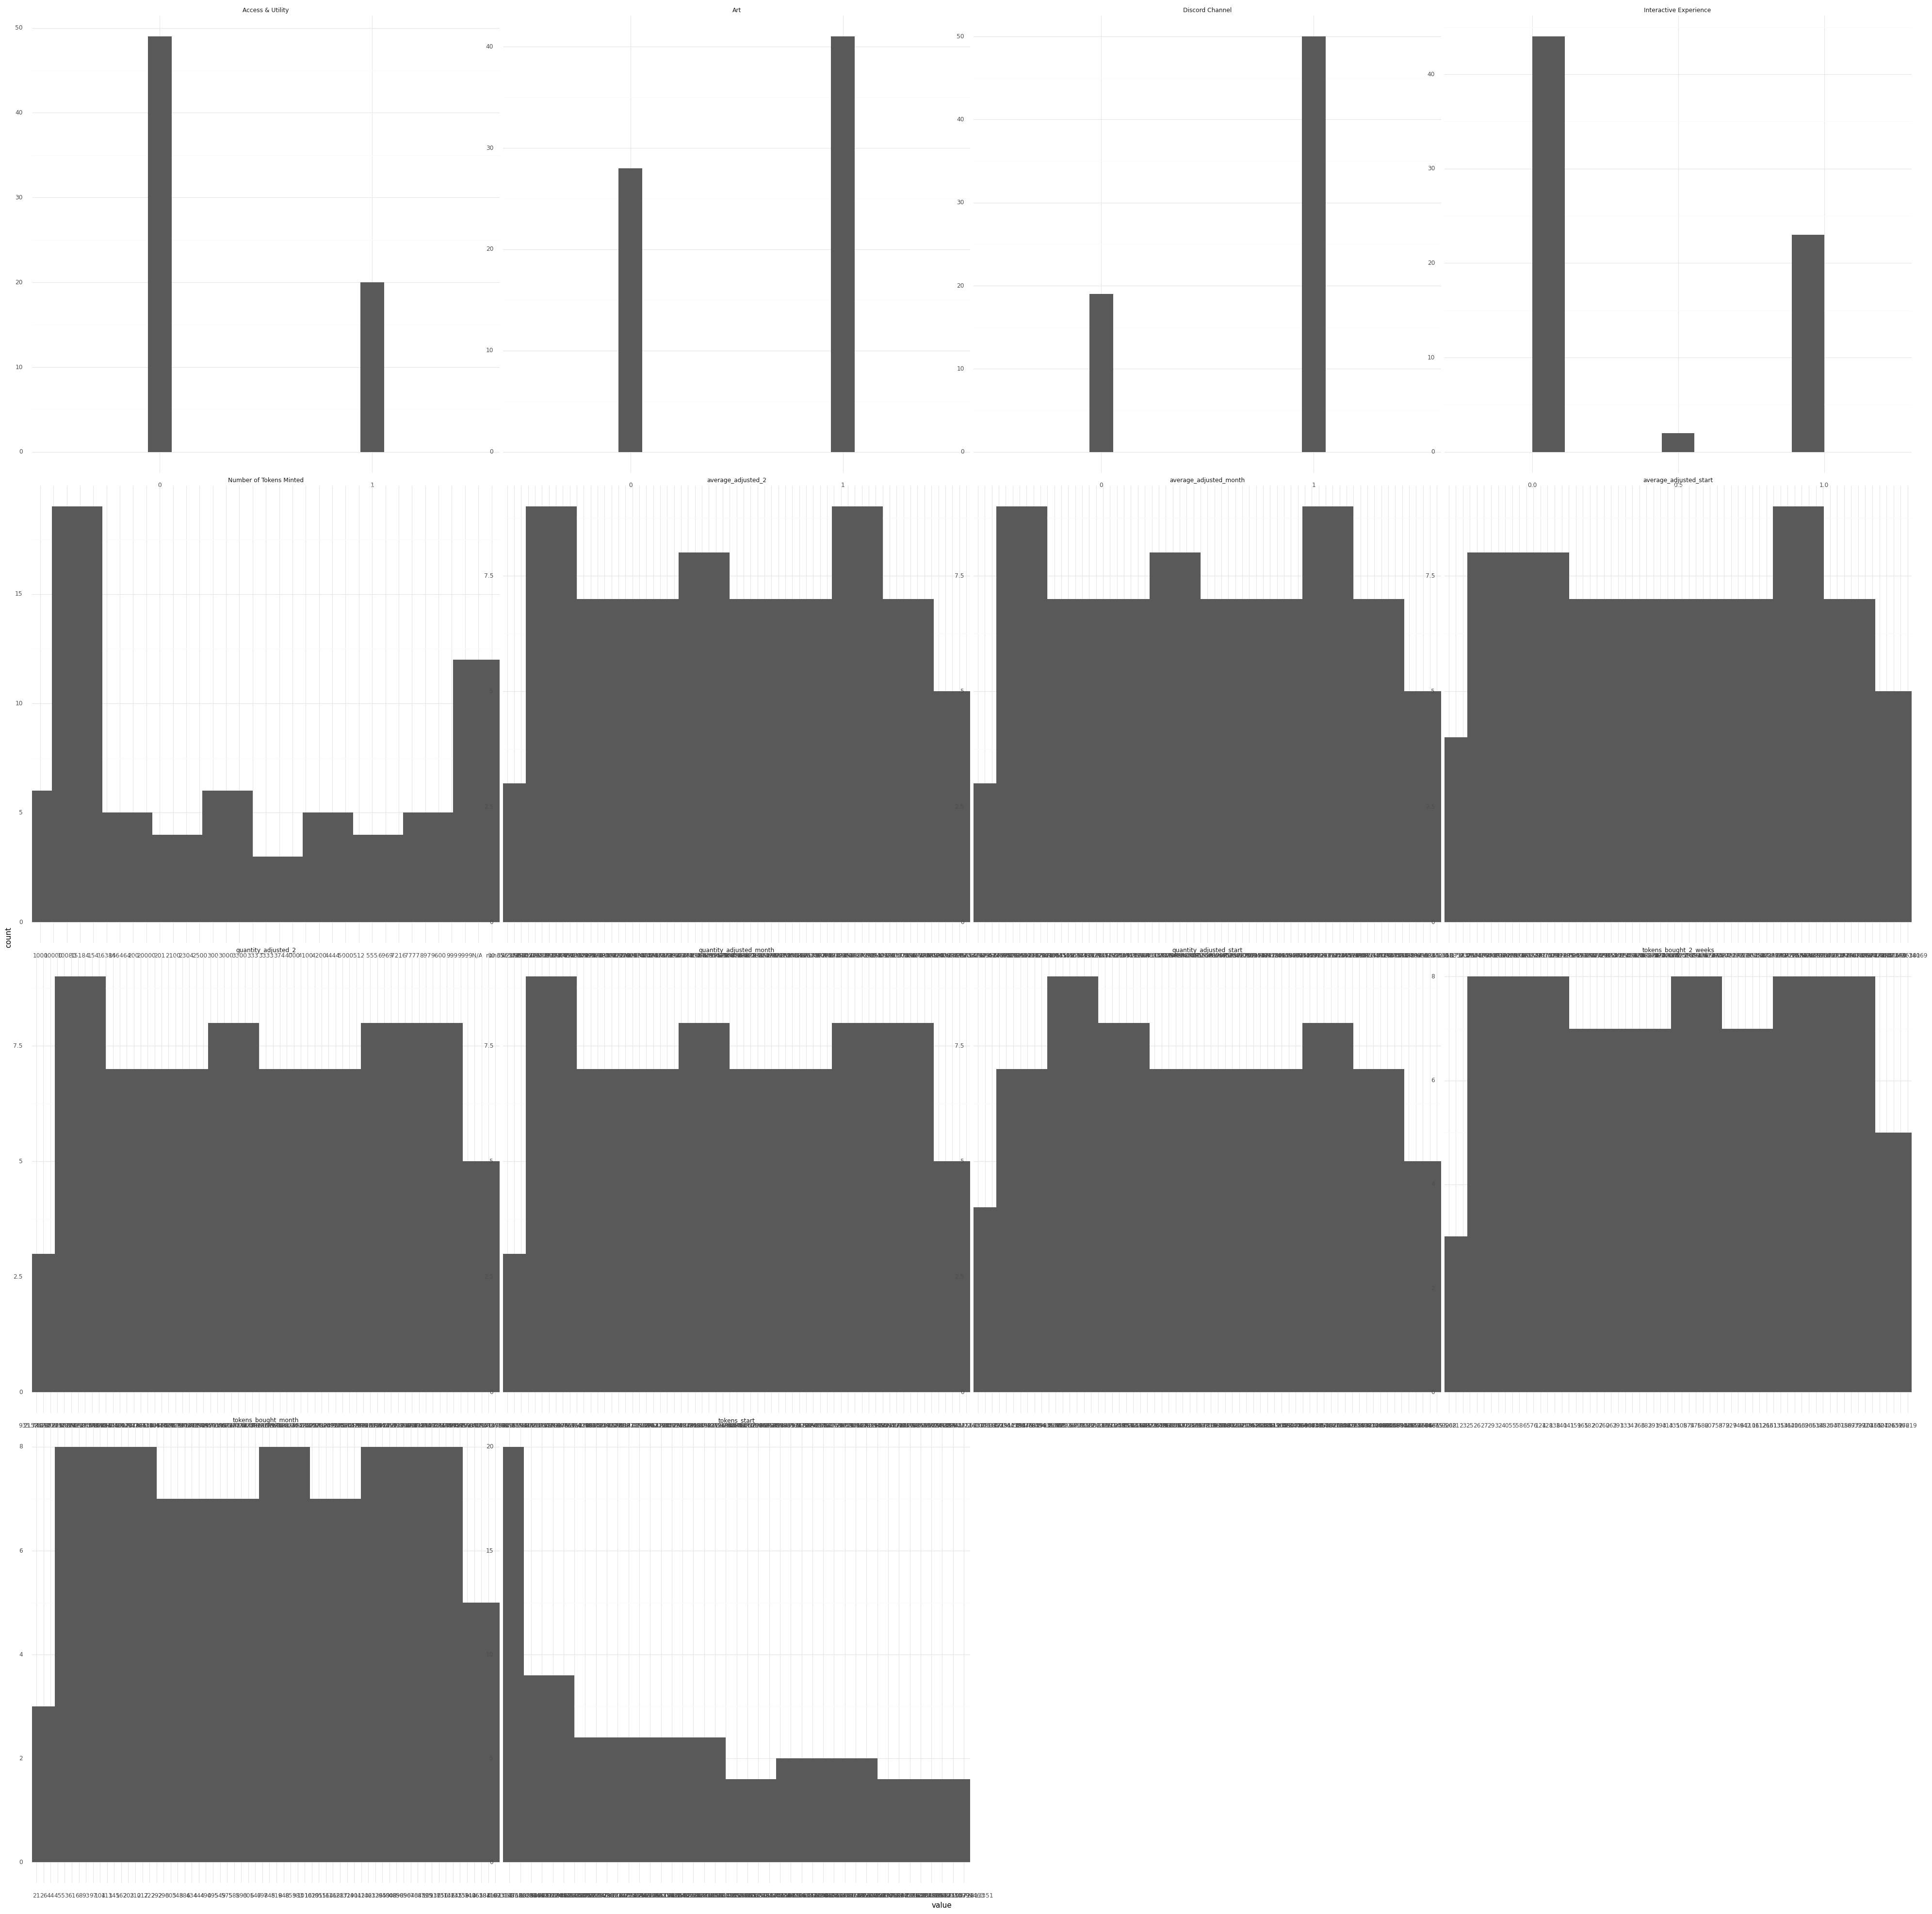

<ggplot: (323679310)>

In [9]:
# IVs
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (50,50)) 
) 

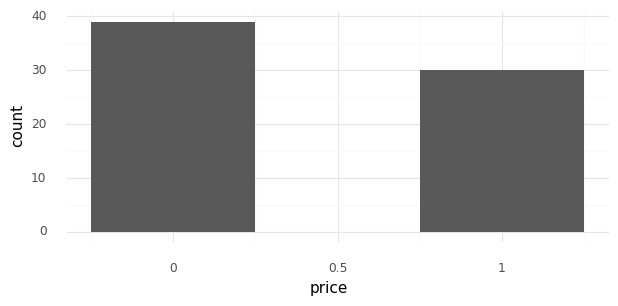

<ggplot: (339106038)>

In [10]:
# DV 
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

### Modeling 

In [62]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1988)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Number of Tokens Minted','quantity_adjusted_start', 'average_adjusted_start', 'tokens_start', 'Art','Discord Channel','Interactive Experience ', 'Access & Utility'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [

     # Naive Bayes
    {'model' : [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,5]}]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Number '
                                                                          'of '
                                                                          'Tokens '
                                                                          'Minted',
                                                                          'quantity_adjusted_start',
                                                                          'average_adjusted_start',
                                                                          'tokens_start',
                                                                          'Art',
     

In [63]:
search.best_score_ # Mean out-of-sample (CV) error

-0.2593406593406593

In [64]:
search.best_params_

{'model': DecisionTreeClassifier(max_depth=2), 'model__max_depth': 2}

In [65]:
pred_y = search.predict(test_X)

### Test Overfitting

In [66]:
pred_train_y = search.predict(train_X)

In [67]:
accuracy_score(test_y, pred_y)

0.7083333333333334

In [68]:
accuracy_score(train_y, pred_train_y)

0.8260869565217391

### Accuracy Assessment

In [69]:
cf_matrix = confusion_matrix(test_y, pred_y)

In [70]:
accuracy_score(test_y, pred_y)

0.7083333333333334

<AxesSubplot:>

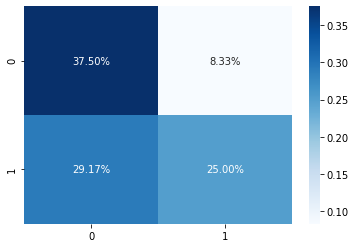

In [50]:
# Heatmap of confusion matrix 
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<AxesSubplot:>

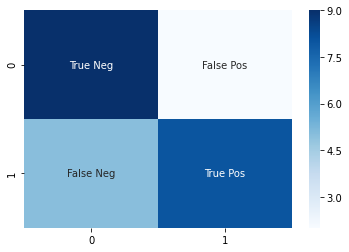

In [83]:
labels = ['True Neg','False Pos', 'False Neg', 'True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

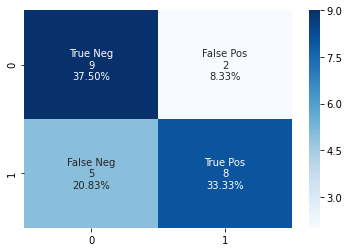

In [87]:
group_names = ['True Neg','False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Variable Permutation 

In [20]:
rf_mod = search.best_estimator_
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=50)

In [21]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Interactive Experience,0.207246,0.050058,0.107131,0.307362
1,average_adjusted_start,0.105797,0.032048,0.041700,0.169894
2,quantity_adjusted_start,0.098841,0.028795,0.041251,0.156431
3,Number of Tokens Minted,0.000000,0.000000,0.000000,0.000000
4,tokens_start,0.000000,0.000000,0.000000,0.000000
5,Art,0.000000,0.000000,0.000000,0.000000
6,Discord Channel,0.000000,0.000000,0.000000,0.000000
7,Access & Utility,0.000000,0.000000,0.000000,0.000000


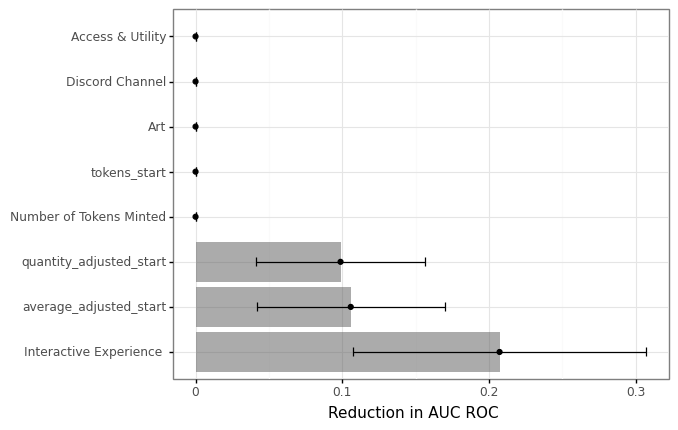

<ggplot: (313160445)>

In [42]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

In [56]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1988)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['quantity_adjusted_start', 'average_adjusted_start', 'Interactive Experience '])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [

     # Naive Bayes
    {'model' : [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,5]}]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['quantity_adjusted_start',
                                                                          'average_adjusted_start',
                                                                          'Interactive '
                                                                          'Experience '])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeClassifier(m

In [57]:
pred_train_y = search.predict(train_X)

In [ ]:
# Test
accuracy_score(test_y, pred_y)

In [ ]:
# Train
accuracy_score(train_y, pred_train_y)